# Project 2: Adversarial Search in AI 
## Applying Kalman Filters for Airplane Tracking 

# Import Statements

In [607]:
from project2_base import *
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator
import seaborn as sns
import traffic
from pykalman import KalmanFilter
from datetime import timedelta
from geopy import distance as dist
from geopy.distance import geodesic
from copy import deepcopy

# Data Loading and Initial Exploration

In [608]:
# Load the data
datas = get_ground_truth_data()
print(datas)
print(type(datas))

# Extract a list of flight IDs and store it as a variable called flight_ids
flight_ids = list(datas.keys())
print(flight_ids)

# Extract a list of tuples with (flight_id, flight_data)
flights_info = [(flight_id, flight_data) for flight_id, flight_data in datas.items()]
print(flights_info)

reading data of flight: IGRAD_000
ERROR: duplicate flight ids: IGRAD_000
reading data of flight: IGRAD_000
reading data of flight: PXR31F_001
ERROR: duplicate flight ids: PXR31F_001
reading data of flight: PXR31F_001
reading data of flight: N441FS_002
ERROR: duplicate flight ids: N441FS_002
reading data of flight: N441FS_002
reading data of flight: N441FS_003
ERROR: duplicate flight ids: N441FS_003
reading data of flight: N441FS_003
reading data of flight: OKVOK_004
ERROR: duplicate flight ids: OKVOK_004
reading data of flight: OKVOK_004
reading data of flight: FGALN_005
ERROR: duplicate flight ids: FGALN_005
reading data of flight: FGALN_005
reading data of flight: FGALN_006
ERROR: duplicate flight ids: FGALN_006
reading data of flight: FGALN_006
reading data of flight: HAYCG_007
ERROR: duplicate flight ids: HAYCG_007
reading data of flight: HAYCG_007
reading data of flight: FGALN_008
ERROR: duplicate flight ids: FGALN_008
reading data of flight: FGALN_008
reading data of flight: FAF4

### Example for the first flight  

In [609]:
datas["IGRAD_000"]
print (type(datas["IGRAD_000"]))

<class 'traffic.core.flight.Flight'>


In [610]:
dict(datas["IGRAD_000"])

{'flight_id': 'IGRAD_000',
 'callsign': 'IGRAD',
 'icao24': '3006bd',
 'aircraft': Tail(icao24='3006bd', registration='I-GRAD', typecode='P68', flag='🇮🇹'),
 'start': Timestamp('2020-04-15 07:39:00+0000', tz='UTC'),
 'stop': Timestamp('2020-04-15 11:51:30+0000', tz='UTC'),
 'duration': Timedelta('0 days 04:12:30')}

In [611]:
datas["IGRAD_000"].data

,timestamp,icao24,latitude,longitude,groundspeed,track,vertical_rate,callsign,squawk,altitude,flight_id
0,2020-04-15 07:39:00+00:00,3006bd,44.362427,8.699668,106.0,234.0,128.0,IGRAD,0,1300.0,IGRAD_000
1,2020-04-15 07:39:10+00:00,3006bd,44.359535,8.694004,111.0,234.0,-64.0,IGRAD,0,1275.0,IGRAD_000
2,2020-04-15 07:39:20+00:00,3006bd,44.356659,8.687897,109.0,239.0,0.0,IGRAD,0,1275.0,IGRAD_000
3,2020-04-15 07:39:30+00:00,3006bd,44.351807,8.678462,109.0,230.0,384.0,IGRAD,0,1275.0,IGRAD_000
4,2020-04-15 07:39:40+00:00,3006bd,44.348503,8.673103,104.0,229.0,768.0,IGRAD,4201,1375.0,IGRAD_000
...,...,...,...,...,...,...,...,...,...,...,...
1511,2020-04-15 11:50:50+00:00,3006bd,44.393284,8.869719,89.0,14.0,-1024.0,IGRAD,4201,525.0,IGRAD_000
1512,2020-04-15 11:51:00+00:00,3006bd,44.397491,8.871264,84.0,17.0,-576.0,IGRAD,4201,350.0,IGRAD_000
1513,2020-04-15 11:51:10+00:00,3006bd,44.403214,8.872637,74.0,7.0,-576.0,IGRAD,4201,250.0,IGRAD_000
1514,2020-04-15 11:51:20+00:00,3006bd,44.404781,8.871593,71.0,318.0,-832.0,IGRAD,4201,200.0,IGRAD_000


In [612]:
print(type(datas["IGRAD_000"].data))

<class 'pandas.core.frame.DataFrame'>


/opt/anaconda3/envs/traffic/lib/python3.10/site-packages/traffic/core/flight.py:1719: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  value = getattr(data.iloc[:, idx], meth)()
/opt/anaconda3/envs/traffic/lib/python3.10/site-packages/traffic/core/flight.py:1721: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  value = value.fillna(method="pad")


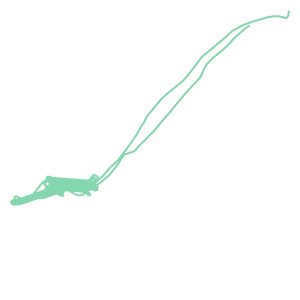

In [613]:
datas["IGRAD_000"].between("2020-04-15 07:00", "2020-04-15 12:00")

In [614]:
datas["IGRAD_000"].between("2020-04-15 07:00", "2020-04-15 12:00").data

,timestamp,icao24,latitude,longitude,groundspeed,track,vertical_rate,callsign,squawk,altitude,flight_id
0,2020-04-15 07:39:00+00:00,3006bd,44.362427,8.699668,106.0,234.0,128.0,IGRAD,0,1300.0,IGRAD_000
1,2020-04-15 07:39:10+00:00,3006bd,44.359535,8.694004,111.0,234.0,-64.0,IGRAD,0,1275.0,IGRAD_000
2,2020-04-15 07:39:20+00:00,3006bd,44.356659,8.687897,109.0,239.0,0.0,IGRAD,0,1275.0,IGRAD_000
3,2020-04-15 07:39:30+00:00,3006bd,44.351807,8.678462,109.0,230.0,384.0,IGRAD,0,1275.0,IGRAD_000
4,2020-04-15 07:39:40+00:00,3006bd,44.348503,8.673103,104.0,229.0,768.0,IGRAD,4201,1375.0,IGRAD_000
...,...,...,...,...,...,...,...,...,...,...,...
1511,2020-04-15 11:50:50+00:00,3006bd,44.393284,8.869719,89.0,14.0,-1024.0,IGRAD,4201,525.0,IGRAD_000
1512,2020-04-15 11:51:00+00:00,3006bd,44.397491,8.871264,84.0,17.0,-576.0,IGRAD,4201,350.0,IGRAD_000
1513,2020-04-15 11:51:10+00:00,3006bd,44.403214,8.872637,74.0,7.0,-576.0,IGRAD,4201,250.0,IGRAD_000
1514,2020-04-15 11:51:20+00:00,3006bd,44.404781,8.871593,71.0,318.0,-832.0,IGRAD,4201,200.0,IGRAD_000


# Data Analysis

### Helper functions


In [615]:
def calculate_duration(flight_data):
    """
    Calculates the duration of the flight
    
    Args:
        flight_data (pandas.DataFrame): The flight data containing 'timestamp' column.
    
    Returns:
        pandas.Timedelta: The duration of the flight.
    """
    duration = flight_data['timestamp'].max() - flight_data['timestamp'].min()
    return duration

In [616]:
def analyze_altitude(flight_data):
    """
    Analyzes the altitude data of the flight.
    
    Args:
        flight_data (pandas.DataFrame): The flight data containing 'altitude' column.
    
    Returns:
        dict: A dictionary containing max, min, and average altitude.
    """
    max_altitude = flight_data['altitude'].max()
    min_altitude = flight_data['altitude'].min()
    avg_altitude = flight_data['altitude'].mean()
    
    return {'max_altitude': max_altitude, 'min_altitude': min_altitude, 'avg_altitude': avg_altitude}

In [617]:
def estimate_route_complexity(flight_data, change_threshold=20):
    """
    Estimates the route complexity by counting the number of significant directional changes.
    
    Args:
        flight_data (pandas.DataFrame): The flight data containing 'latitude' and 'longitude' columns.
        change_threshold (int): The change in bearing considered significant, in degrees.
    
    Returns:
        int: The estimated route complexity, defined by the number of significant turns.
    """
    num_turns = 0
    last_bearing = None
    
    for i in range(1, len(flight_data)):
        prev_point = (flight_data.iloc[i - 1]['latitude'], flight_data.iloc[i - 1]['longitude'])
        current_point = (flight_data.iloc[i]['latitude'], flight_data.iloc[i]['longitude'])
        
        # Calculate bearing between consecutive points
        delta_lon = np.radians(current_point[1] - prev_point[1])
        y = np.sin(delta_lon) * np.cos(np.radians(current_point[0]))
        x = np.cos(np.radians(prev_point[0])) * np.sin(np.radians(current_point[0])) - \
            np.sin(np.radians(prev_point[0])) * np.cos(np.radians(current_point[0])) * np.cos(delta_lon)
        current_bearing = np.degrees(np.arctan2(y, x)) % 360
        
        if last_bearing is not None:
            bearing_change = abs(current_bearing - last_bearing)
            bearing_change = min(bearing_change, 360 - bearing_change)  # Correct for angular wraparound
            if bearing_change > change_threshold:
                num_turns += 1
        
        last_bearing = current_bearing
    
    return num_turns

### Anaylse Duration, Altitude, and Route Complexity for each flight

In [618]:
# Initialize a dictionary to store the results
results = {}

# Iterating through each flight in the dataset
for flight_id, flight in datas.items():
    
    # Access the DataFrame directly
    flight_data = flight.data  # Since it's already a DataFrame
    
    # Ensure the DataFrame is not empty
    if not flight_data.empty:
        # Calculate flight duration
        duration = calculate_duration(flight_data)

        # Analyze altitude data
        altitude_info = analyze_altitude(flight_data)

        # Estimate route complexity
        complexity = estimate_route_complexity(flight_data)  # Make sure this function is defined and adapted to your data structure

        # Store the results for the current flight
        results[flight_id] = {
            'duration': duration,
            'max_altitude': altitude_info['max_altitude'],
            'min_altitude': altitude_info['min_altitude'],
            'avg_altitude': altitude_info['avg_altitude'],
            'route_complexity': complexity
        }
    else:
        print(f"Warning: No data available for flight {flight_id}")

# Print out the results for each flight
for flight_id, metrics in results.items():
    print(f"Flight ID: {flight_id}")
    print(f"Duration: {metrics['duration']}")
    print(f"Max Altitude: {metrics['max_altitude']} meters")
    print(f"Min Altitude: {metrics['min_altitude']} meters")
    print(f"Average Altitude: {metrics['avg_altitude']} meters")
    print(f"Route Complexity (number of significant turns): {metrics['route_complexity']}")
    print("---------------------------------------------------------")

Flight ID: IGRAD_000
Duration: 0 days 04:12:30
Max Altitude: 4250.0 meters
Min Altitude: 100.0 meters
Average Altitude: 3251.500659630607 meters
Route Complexity (number of significant turns): 183
---------------------------------------------------------
Flight ID: PXR31F_001
Duration: 0 days 04:40:30
Max Altitude: 4100 meters
Min Altitude: 1200 meters
Average Altitude: 3850.78834524464 meters
Route Complexity (number of significant turns): 350
---------------------------------------------------------
Flight ID: N441FS_002
Duration: 0 days 05:08:42
Max Altitude: 16200 meters
Min Altitude: 1300 meters
Average Altitude: 14419.602649006623 meters
Route Complexity (number of significant turns): 58
---------------------------------------------------------
Flight ID: N441FS_003
Duration: 0 days 04:35:15
Max Altitude: 16900 meters
Min Altitude: 1300 meters
Average Altitude: 15302.418207681365 meters
Route Complexity (number of significant turns): 52
-------------------------------------------

### Plot the graph

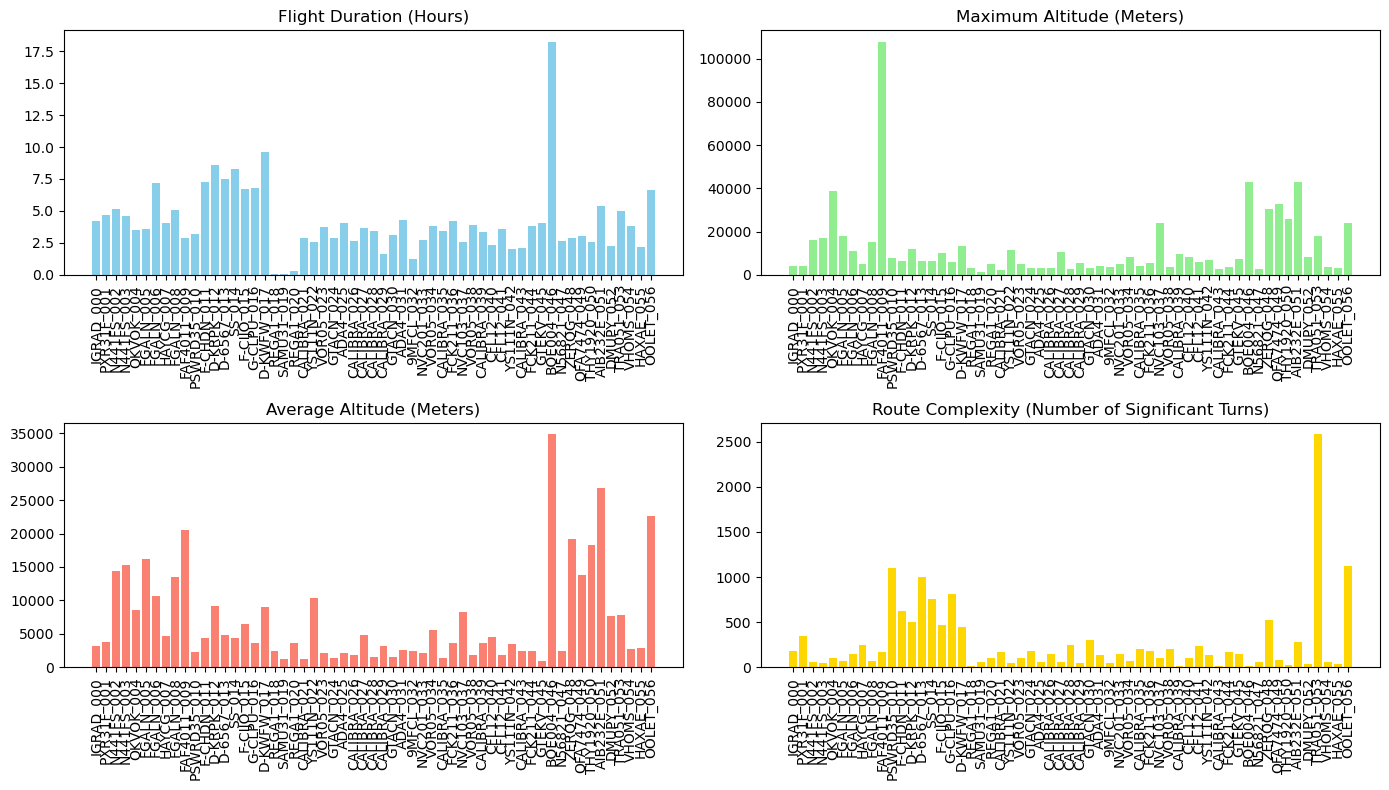

In [619]:
# Prepare lists for plotting
flight_ids = list(results.keys())
durations = [result['duration'].total_seconds()/3600 for result in results.values()]  # Convert duration to hours
max_altitudes = [result['max_altitude'] for result in results.values()]
min_altitudes = [result['min_altitude'] for result in results.values()]
avg_altitudes = [result['avg_altitude'] for result in results.values()]
route_complexities = [result['route_complexity'] for result in results.values()]

# Plotting
plt.figure(figsize=(14, 8))

# Plot for flight duration
plt.subplot(2, 2, 1)  # 2 rows, 2 columns, 1st subplot
plt.bar(flight_ids, durations, color='skyblue')
plt.title('Flight Duration (Hours)')
plt.xticks(rotation=90)

# Plot for maximum altitude
plt.subplot(2, 2, 2)  # 2 rows, 2 columns, 2nd subplot
plt.bar(flight_ids, max_altitudes, color='lightgreen')
plt.title('Maximum Altitude (Meters)')
plt.xticks(rotation=90)

# Plot for average altitude
plt.subplot(2, 2, 3)  # 2 rows, 2 columns, 3rd subplot
plt.bar(flight_ids, avg_altitudes, color='salmon')
plt.title('Average Altitude (Meters)')
plt.xticks(rotation=90)

# Plot for route complexity
plt.subplot(2, 2, 4)  # 2 rows, 2 columns, 4th subplot
plt.bar(flight_ids, route_complexities, color='gold')
plt.title('Route Complexity (Number of Significant Turns)')
plt.xticks(rotation=90)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

# Plot Functions

In [620]:
def plot_actual_radar_all(actual_data, radar_data, 
                          n_minor_ticks_x=0, n_minor_ticks_longitude=0, 
                          n_minor_ticks_latitude=0, 
                          actual_data_label_latitude='Latitude (Actual)', radar_data_label_latitude='Latitude (Radar)',
                          actual_data_label_longitude='Longitude (Actual)', radar_data_label_longitude='Longitude (Radar)'):
    """Plots a graph of longitude, latitude against time for both actual and radar flight data.

    Args:
        actual_data (panda.DataFrame): The actual data to be plotted
        radar_data (panda.DataFrame): The radar data to be plotted
        n_minor_ticks_x (integer): The number of minor axis intervals for time axis
        n_minor_ticks_longitude (integer): The number of minor axis intervals for longitude axis
        n_minor_ticks_latitude (integer): The number of minor axis intervals for latitude axis
        actual_data_label_latitude (string): Label for actual data (Latitude) 
        radar_data_label_latitude (string): Label for radar data (Latitude)
        actual_data_label_longitude (string): Label for actual data (Longitude) 
        radar_data_label_longitude (string): Label for radar data (Longitude) 
    """
    # Plotting
    fig, ax1 = plt.subplots()

    # Set the x-axis as the timestamp
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Latitude', color='tab:red')
    ax1.plot(actual_data['timestamp'], actual_data['latitude'], color='tab:red', label=actual_data_label_latitude)
    ax1.plot(radar_data['timestamp'], radar_data['latitude'], color='tab:pink', label=radar_data_label_latitude, linestyle='--')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # Create a second y-axis for longitude
    ax2 = ax1.twinx()
    ax2.set_ylabel('Longitude', color='tab:blue')
    ax2.plot(actual_data['timestamp'], actual_data['longitude'], color='tab:blue', label=actual_data_label_longitude)
    ax2.plot(radar_data['timestamp'], radar_data['longitude'], color='tab:cyan', label=radar_data_label_longitude, linestyle='--')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    # Add a title
    plt.title('Latitude and Longitude over Time')

    # Show legends
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # Set minor ticks between the major ticks
    ax1.xaxis.set_minor_locator(AutoMinorLocator(n_minor_ticks_x))
    ax1.yaxis.set_minor_locator(AutoMinorLocator(n_minor_ticks_latitude))
    ax2.yaxis.set_minor_locator(AutoMinorLocator(n_minor_ticks_longitude)) 

    # Color of the minor ticks
    ax1.tick_params(axis='y', which='minor', color='tab:red')
    ax2.tick_params(axis='y', which='minor', color='tab:blue')

    # Add vertical grid lines to the plot
    ax1.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5)

    # Add horizontal grid lines to the plot for latitude
    ax1.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5, color='tab:red', alpha=0.5)

    # Add horizontal grid lines to the plot for longitude
    ax2.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5, color='tab:blue', alpha=0.5)

    plt.show()

In [621]:
def plot_actual_radar_latitude(actual_data, radar_data, 
                               n_minor_ticks_x=0, n_minor_ticks_latitude=0,
                               actual_data_label_latitude='Latitude (Actual)', radar_data_label_latitude='Latitude (Radar)'):
    """Plots a graph of latitude against time for both actual and radar flight data.

    Args:
        actual_data (panda.DataFrame): The actual data to be plotted
        radar_data (panda.DataFrame): The radar data to be plotted
        n_minor_ticks_x (integer): The number of minor axis intervals for time axis
        n_minor_ticks_latitude (integer): The number of minor axis intervals for latitude axis
        actual_data_label_latitude (string): Label for actual data (Latitude) 
        radar_data_label_latitude (string): Label for radar data (Latitude)
    """
    # Plotting
    fig, ax1 = plt.subplots()

    # Set the x-axis as the timestamp
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Latitude', color='tab:red')
    ax1.plot(actual_data['timestamp'], actual_data['latitude'], color='tab:red', label=actual_data_label_latitude)
    ax1.plot(radar_data['timestamp'], radar_data['latitude'], color='tab:pink', label=radar_data_label_latitude, linestyle='--')
    ax1.tick_params(axis='y', labelcolor='tab:red')
    
    # Add a title
    plt.title('Latitude over Time')

    # Show legends
    ax1.legend(loc='upper left')

    # Set minor ticks between the major ticks
    ax1.xaxis.set_minor_locator(AutoMinorLocator(n_minor_ticks_x))
    ax1.yaxis.set_minor_locator(AutoMinorLocator(n_minor_ticks_latitude))

    # Color of the minor ticks
    ax1.tick_params(axis='y', which='minor', color='tab:red')

    # Add vertical grid lines to the plot
    ax1.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5)

    # Add horizontal grid lines to the plot for latitude
    ax1.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5, color='tab:red', alpha=0.5)

    plt.show()

In [622]:
def plot_actual_radar_longitude(actual_data, radar_data, 
                                n_minor_ticks_x=0, n_minor_ticks_longitude=0,
                                actual_data_label_longitude='Longitude (Actual)', radar_data_label_longitude='Longitude (Radar)'):
    """Plots a graph of longitude against time for both actual and radar flight data.

    Args:
        actual_data (panda.DataFrame): The actual data to be plotted
        radar_data (panda.DataFrame): The radar data to be plotted
        n_minor_ticks_x (integer): The number of minor axis intervals for time axis
        n_minor_ticks_longitude (integer): The number of minor axis intervals for longitude axis
        actual_data_label_longitude='Longitude (Actual)', radar_data_label_longitude='Longitude (Radar)'
        actual_data_label_longitude (string): Label for actual data (Longitude) 
        radar_data_label_longitude (string): Label for radar data (Longitude) 
    """
    # Plotting
    fig, ax1 = plt.subplots()

    # Set the x-axis as the timestamp
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Longitude', color='tab:red')
    ax1.plot(actual_data['timestamp'], actual_data['longitude'], color='tab:red', label=actual_data_label_longitude)
    ax1.plot(radar_data['timestamp'], radar_data['longitude'], color='tab:pink', label=radar_data_label_longitude, linestyle='--')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # Add a title
    plt.title('Longitude over Time')

    # Show legends
    ax1.legend(loc='upper left')

    # Set minor ticks between the major ticks
    ax1.xaxis.set_minor_locator(AutoMinorLocator(n_minor_ticks_x))
    ax1.yaxis.set_minor_locator(AutoMinorLocator(n_minor_ticks_longitude))

    # Color of the minor ticks
    ax1.tick_params(axis='y', which='minor', color='tab:blue')

    # Add vertical grid lines to the plot
    ax1.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5)

    # Add horizontal grid lines to the plot for longitude
    ax1.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5, color='tab:red', alpha=0.5)

    plt.show()

# Kalman Filtering

### Define Kalman Filter Parameters

In [623]:
def construct_kalman_filter(radar_data, delta_time=10):
    """Takes the radar data and defines the kalman filter model for the radar model

    Args:
        radar_data (pandas.DataFrame): Radar data to be used for constructing the Kalman Filter model.
        delta_time (int, optional): The time between each sampling. Defaults to 10.
    """

    dim_x = 4
    dim_z = 2
    standard_deviation_process = 1.5  # Standard Deviation for acceleration  (Plane example)
    standard_deviation_observation = 3  # Standard Deviation for radar measurement

    # Initialize the Kalman Filter
    kf = KalmanFilter(dim_x, dim_z)

    # Define the initial state estimate
    initial_position = np.array([radar_data.x.iloc[0], radar_data.y.iloc[0], 0., 0.])  # Assuming initial velocity is 0
    kf.initial_state_mean = initial_position

    # Define the state transition matrix (F)
    kf.transition_matrices = np.array([[1, 0, delta_time, 0],
                    [0, 1, 0, delta_time],
                    [0, 0, 1, 0],
                    [0, 0, 0, 1]])

    # Define the process noise covariance matrix (Q)

    a = (1/4 * delta_time**4) * (standard_deviation_process**2)
    b = (1/2 * delta_time**3) * (standard_deviation_process**2)
    c = delta_time**2 * (standard_deviation_process**2)
    kf.transition_covariance = np.array(
                    [[a, 0, b, 0],
                    [0, a, 0, b],
                    [b, 0, c, 0],
                    [0, b, 0, c]])

    # Define the observation matrix (H)
    kf.observation_matrices = np.array([[1, 0, 0, 0],
                    [0, 1, 0, 0]]) 

    # Define the measurement noise covariance matrix (R)
    kf.observation_covariance = np.array([[standard_deviation_observation**2, 0],
                    [0, standard_deviation_observation**2]])
    
    
    
    return kf

### Applying Kalman Filter on a random selection of flight IDs, on the entire duration

In [637]:
# FOR FIRST 20 MINUTES 
# # Randomly select flight IDs from your dataset
# selected_flight_ids = random.sample(list(datas.keys()), 50)  # Change 10 to the desired number of flights

# # Dictionary to store results for analysis
# experiment_results = {}

# # Loop through each selected flight ID
# for flight_id in selected_flight_ids:
#     print(f"Processing flight: {flight_id}")
#     flight = datas[flight_id]  # Retrieve the flight data

#     # Ensure the flight exists and has data
#     if flight is None or flight.data.empty:
#         print(f"Skipping flight {flight_id} due to missing or empty data.")
#         continue

#     # Sort flight data by timestamp and determine the time range for the first 20 minutes
#     flight_data_sorted = flight.data.sort_values(by='timestamp')
#     actual_start_time = flight_data_sorted['timestamp'].min()
#     actual_end_time = actual_start_time + pd.Timedelta(minutes=20)

#     # Extract actual data for this time range
#     actual_data = flight_data_sorted[(flight_data_sorted['timestamp'] >= actual_start_time) & (flight_data_sorted['timestamp'] <= actual_end_time)]

#     # Check if there is actual data within the first 20 minutes
#     if actual_data.empty:
#         print(f"Skipping flight {flight_id} due to lack of actual data in the first 20 minutes.")
#         continue

#     # Generate radar data for the same time range and ensure it exists
#     radar_data = get_radar_data_for_flight(flight).between(actual_start_time, actual_end_time).data
#     if radar_data.empty:
#         print(f"Skipping flight {flight_id} due to lack of radar data in the first 20 minutes.")
#         continue

#     # Construct and apply the Kalman filter based on radar data
#     kf = construct_kalman_filter(radar_data) 
#     radar_measurements = np.column_stack((radar_data['x'], radar_data['y']))  # Make sure 'x' and 'y' match your radar data columns
#     filtered_state_means, filtered_state_covariances = kf.filter(radar_measurements)
   
#     # Apply smoothing to the Kalman filter
#     smoothed_state_means, smoothed_state_covariances = kf.smooth(radar_measurements)

#     # Store the filtering results for further analysis
#     experiment_results[flight_id] = {
#         'actual_data': actual_data, 
#         'radar_data': radar_data,
#         'filtered_means': filtered_state_means,
#         'smoothed_means': smoothed_state_means
#     }

# Randomly select flight IDs from your dataset
selected_flight_ids = random.sample(list(datas.keys()), 5)  # Change 50 to the desired number of flights

# Dictionary to store results for analysis
experiment_results = {}

# Loop through each selected flight ID
for flight_id in selected_flight_ids:
    print(f"Processing flight: {flight_id}")
    flight = deepcopy(datas[flight_id])  # Make a deep copy of the flight data to avoid altering the original

    actual_data = flight.data

    # Ensure the flight exists and has data
    if flight is None or flight.data.empty:
        print(f"Skipping flight {flight_id} due to missing or empty data.")
        continue

    # Generate radar data for the same time range and ensure it exists
    radar_data = get_radar_data_for_flight(flight).data
    if radar_data.empty:
        print(f"Skipping flight {flight_id} due to lack of radar data in the first 20 minutes.")
        continue

    # Construct and apply the Kalman filter based on radar data
    kf = construct_kalman_filter(radar_data) 
    radar_measurements = np.column_stack((radar_data['x'], radar_data['y']))  # Make sure 'x' and 'y' match your radar data columns
    filtered_state_means, filtered_state_covariances = kf.filter(radar_measurements)
   
    # Apply smoothing to the Kalman filter
    smoothed_state_means, smoothed_state_covariances = kf.smooth(radar_measurements)

    # Only proceed if lengths match; otherwise, note the discrepancy
    if len(radar_data) == len(filtered_state_means) and len(radar_data) == len(smoothed_state_means):
       # Create deep copies for filtered and smoothed data updates
        filtered_flight_data = deepcopy(flight.data)
        smoothed_flight_data = deepcopy(flight.data)

        # Update 'x', 'y' in the deep copies based on filtered/smoothed values
        for idx, _ in enumerate(filtered_state_means):  # Use enumerate to get the index
            if idx in flight.data.index:
                # Update for filtered states
                filtered_flight_data.at[idx, 'x'] = filtered_state_means[idx, 0]
                filtered_flight_data.at[idx, 'y'] = filtered_state_means[idx, 1]
                
                # Update for smoothed states
                smoothed_flight_data.at[idx, 'x'] = smoothed_state_means[idx, 0]
                smoothed_flight_data.at[idx, 'y'] = smoothed_state_means[idx, 1]

        # Convert updated x, y back to lat, lon for both filtered and smoothed data
        filtered_flight = deepcopy(flight)
        filtered_flight.data = filtered_flight_data
        set_lat_lon_from_x_y(filtered_flight)

        smoothed_flight = deepcopy(flight)
        smoothed_flight.data = smoothed_flight_data
        set_lat_lon_from_x_y(smoothed_flight)
        
        # Store the filtering results for further analysis
        experiment_results[flight_id] = {
            'actual_data': actual_data, 
            'radar_data': radar_data,
            'filtered_means': filtered_flight.data,
            'smoothed_means': smoothed_flight.data
    }
    

Processing flight: ADA4_025
flight: ADA4_025


/opt/anaconda3/envs/traffic/lib/python3.10/site-packages/traffic/core/flight.py:1719: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  value = getattr(data.iloc[:, idx], meth)()
/opt/anaconda3/envs/traffic/lib/python3.10/site-packages/traffic/core/flight.py:1721: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  value = value.fillna(method="pad")
/Users/hongjing/Documents/RU /AI/Project2/KalmanFilterAirRadar/project2_base.py:130: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '914.62353124849' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  flight_radar.data.at[i, "altitude"] = math.tan(height_angle) * dist_to_point


Processing flight: GTEKV_045
flight: GTEKV_045


/opt/anaconda3/envs/traffic/lib/python3.10/site-packages/traffic/core/flight.py:1719: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  value = getattr(data.iloc[:, idx], meth)()
/opt/anaconda3/envs/traffic/lib/python3.10/site-packages/traffic/core/flight.py:1721: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  value = value.fillna(method="pad")


Processing flight: GTACN_030
flight: GTACN_030


/opt/anaconda3/envs/traffic/lib/python3.10/site-packages/traffic/core/flight.py:1719: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  value = getattr(data.iloc[:, idx], meth)()
/opt/anaconda3/envs/traffic/lib/python3.10/site-packages/traffic/core/flight.py:1721: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  value = value.fillna(method="pad")
/Users/hongjing/Documents/RU /AI/Project2/KalmanFilterAirRadar/project2_base.py:130: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-825.0906067711952' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  flight_radar.data.at[i, "altitude"] = math.tan(height_angle) * dist_to_point


Processing flight: CALIBRA_026
flight: CALIBRA_026


/opt/anaconda3/envs/traffic/lib/python3.10/site-packages/traffic/core/flight.py:1719: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  value = getattr(data.iloc[:, idx], meth)()
/opt/anaconda3/envs/traffic/lib/python3.10/site-packages/traffic/core/flight.py:1721: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  value = value.fillna(method="pad")
/Users/hongjing/Documents/RU /AI/Project2/KalmanFilterAirRadar/project2_base.py:130: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '120.79455978179126' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  flight_radar.data.at[i, "altitude"] = math.tan(height_angle) * dist_to_point


Processing flight: THY1920_050
flight: THY1920_050


/opt/anaconda3/envs/traffic/lib/python3.10/site-packages/traffic/core/flight.py:1719: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  value = getattr(data.iloc[:, idx], meth)()
/opt/anaconda3/envs/traffic/lib/python3.10/site-packages/traffic/core/flight.py:1721: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  value = value.fillna(method="pad")


# Data Visualisation

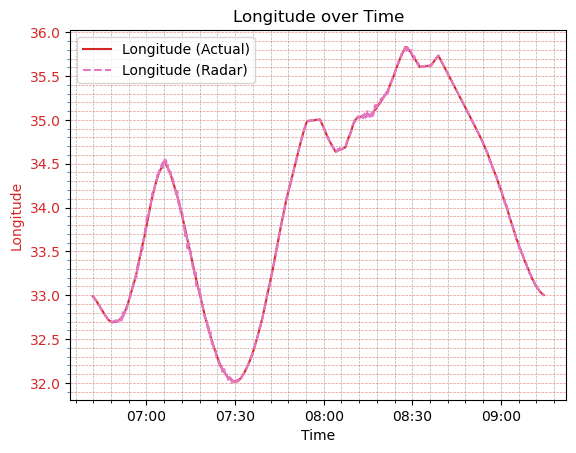

In [638]:
plot_actual_radar_longitude(actual_data, radar_data, 5, 5)

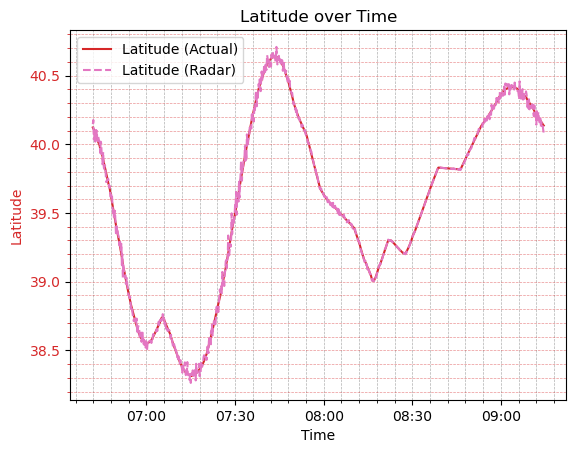

In [639]:
plot_actual_radar_latitude(actual_data, radar_data, 5, 5)

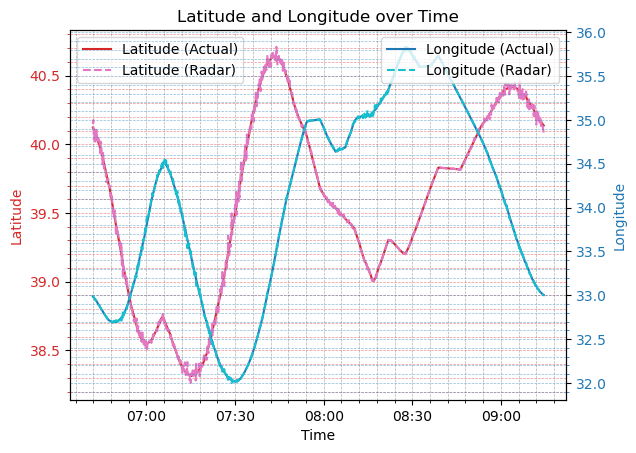

In [640]:
plot_actual_radar_all(actual_data, radar_data, 5, 5, 5)

### TASK 5: Plot filtered position estimates alongisde the original track 

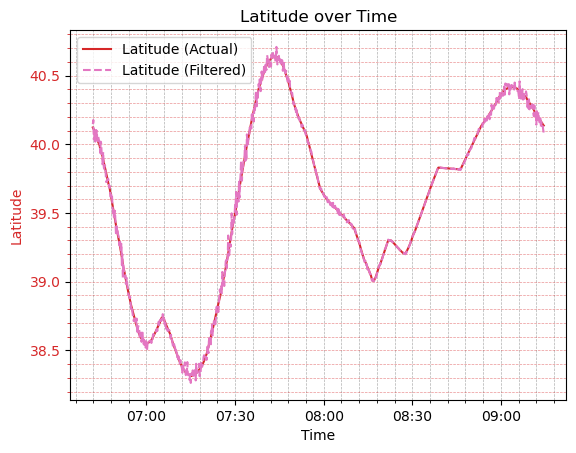

In [641]:
plot_actual_radar_latitude(actual_data, radar_data, 5, 5, radar_data_label_latitude="Latitude (Filtered)")

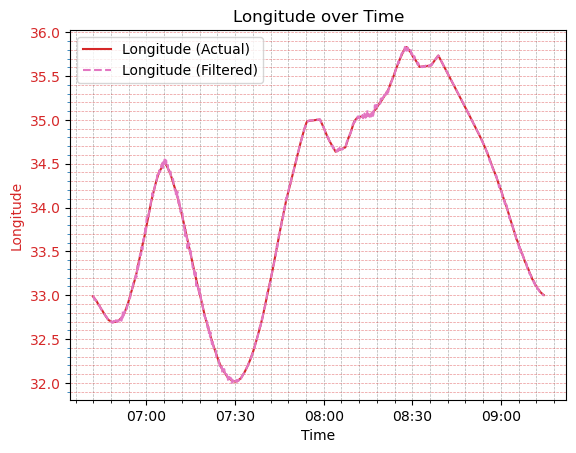

In [642]:
plot_actual_radar_longitude(actual_data, radar_data, 5, 5, radar_data_label_longitude="Longitude (Filtered)")

/opt/anaconda3/envs/traffic/lib/python3.10/site-packages/matplotlib/ticker.py:2927: RuntimeWarning: divide by zero encountered in scalar divide
  minorstep = majorstep / ndivs
/opt/anaconda3/envs/traffic/lib/python3.10/site-packages/matplotlib/ticker.py:2936: RuntimeWarning: invalid value encountered in multiply
  locs = (np.arange(tmin, tmax) * minorstep) + t0


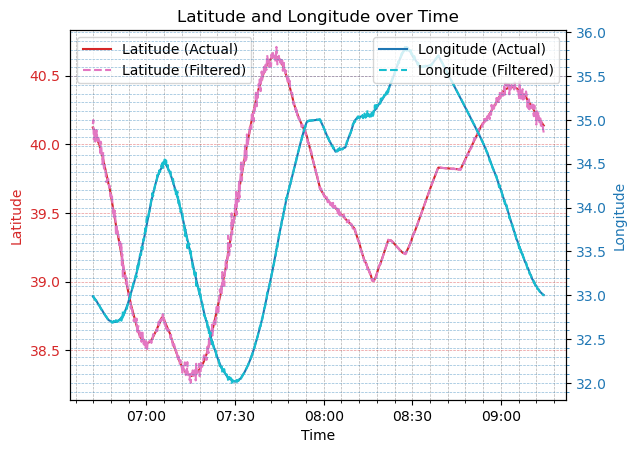

In [643]:
plot_actual_radar_all(actual_data, radar_data, 5, 5, radar_data_label_longitude= "Longitude (Filtered)", radar_data_label_latitude="Latitude (Filtered)")

# Error Measurement and Model Evaluation

### Define Function for calculating mean and maximum distance

In [644]:
def calculate_mean_max_distance(data_1, data_2):
    """returns (mean distance, max distance) of two geo coordinated data.  

    Args:
        data_1 (pandas.DataFrame): DataFrame of tuples with 'latitude' and 'longitude' values
        data_2 (pandas.DataFrame): DataFrame of tuples with 'latitude' and 'longitude' values
    """
    # Initialize list to store distances
    distances = []

    # Iterate through the filtered positions and the original data
    for (data_1_lat, data_1_lon), (data_2_lat, data_2_lon) in zip(zip(data_1.latitude, data_1.longitude), zip(data_2.latitude, data_2.longitude)):
        if pd.isna(data_1_lat) or pd.isna(data_1_lon) or pd.isna(data_2_lat) or pd.isna(data_2_lon):
            continue  # Skip this pair if any NaN values are found
        # Calculate distance between filtered and original positions
        distance = dist.geodesic((data_1_lat, data_1_lon), (data_2_lat, data_2_lon)).meters  # geodesic returns the distance in meters
        distances.append(distance)

    # Compute the mean and maximal distances
    mean_distance = np.mean(distances)
    max_distance = np.max(distances)
    
    return mean_distance, max_distance

### TASK 6: Calculating the mean and max distance

In [645]:
for flight_id, results in experiment_results.items():
    actual_data = results['actual_data']
    radar_data = results['radar_data']

    mean_distance, max_distance = calculate_mean_max_distance(actual_data, radar_data)
    
    print(f"Flight ID: {flight_id}")
    print("Error of filtered states to the position of original data:")
    print(f"Mean Distance: {mean_distance} meters")
    print(f"Max Distance: {max_distance} meters")
    

Flight ID: ADA4_025
Error of filtered states to the position of original data:
Mean Distance: 12399.49865183816 meters
Max Distance: 32910.626875131245 meters
Flight ID: GTEKV_045
Error of filtered states to the position of original data:
Mean Distance: 469.4900608246756 meters
Max Distance: 1976.7136572337722 meters
Flight ID: GTACN_030
Error of filtered states to the position of original data:
Mean Distance: 18005.944182071955 meters
Max Distance: 55637.517163697084 meters
Flight ID: CALIBRA_026
Error of filtered states to the position of original data:
Mean Distance: 11024.082632008338 meters
Max Distance: 29208.377684503535 meters
Flight ID: THY1920_050
Error of filtered states to the position of original data:
Mean Distance: 2159.4449780714685 meters
Max Distance: 15004.642571630964 meters


In [646]:
# print the dataframe actual_data
print(actual_data)

                    timestamp  icao24   latitude  longitude  groundspeed  \
0   2020-04-23 06:41:50+00:00  4ba946  40.122303  32.987949        192.0   
1   2020-04-23 06:42:00+00:00  4ba946  40.113602  32.979675        199.0   
2   2020-04-23 06:42:10+00:00  4ba946  40.108990  32.975403        197.0   
3   2020-04-23 06:42:20+00:00  4ba946  40.099586  32.966976        203.0   
4   2020-04-23 06:42:30+00:00  4ba946  40.089531  32.958424        222.0   
..                        ...     ...        ...        ...          ...   
912 2020-04-23 09:13:50+00:00  4ba946  40.156265  33.020508        153.0   
913 2020-04-23 09:14:00+00:00  4ba946  40.152981  33.017288        152.0   
914 2020-04-23 09:14:10+00:00  4ba946  40.146286  33.010864        149.0   
915 2020-04-23 09:14:20+00:00  4ba946  40.139805  33.004677        151.0   
916 2020-04-23 09:14:30+00:00  4ba946  40.136967  33.001930        143.0   

     track  vertical_rate callsign  squawk  altitude origin destination  \
0    216.0  

### Calculating the filtered_means and smoothed_means

In [647]:
for flight_id, results in experiment_results.items():
    print(f"Flight ID: {flight_id}")
    print("Filtered States:" )
    print(results['filtered_means']) # 2D array <class 'numpy.ndarray'>
    print("Smoothed States:" )
    print(results['smoothed_means'])
    print("---------------------------------------------------------")
    

Flight ID: ADA4_025
Filtered States:
                     timestamp  altitude callsign  groundspeed  icao24  \
0    2018-11-10 00:49:20+00:00       200     ADA4          130  7c1a89   
1    2018-11-10 00:49:25+00:00       275     ADA4          130  7c1a89   
2    2018-11-10 00:49:30+00:00       375     ADA4          135  7c1a89   
3    2018-11-10 00:49:35+00:00       525     ADA4          138  7c1a89   
4    2018-11-10 00:49:40+00:00       849     ADA4          140  7c1a89   
...                        ...       ...      ...          ...     ...   
2942 2018-11-10 04:54:30+00:00        50     ADA4          103  7c1a89   
2943 2018-11-10 04:54:35+00:00        50     ADA4          103  7c1a89   
2944 2018-11-10 04:54:40+00:00        50     ADA4          103  7c1a89   
2945 2018-11-10 04:54:45+00:00        50     ADA4          103  7c1a89   
2946 2018-11-10 04:54:50+00:00        50     ADA4          103  7c1a89   

       latitude   longitude  track  vertical_rate flight_id            x  

Use smoothing to compute estimates for all states based on all the available data. How much
better are the smoothed tracks, compared to the filtered ones? Are there specific areas in
the flights where smoothed tracks are better?

To evaluate how much better the smoothed tracks are compared to the filtered ones, we need to compare the average and maximum distances from the actual flight path for both the filtered and smoothed estimates.    apply this function separately for the filtered and smoothed data against the actual data, then compare these values.



In [648]:
# Initialize dictionaries to store mean and max distances for filtered and smoothed data
filtered_distances = {'mean': [], 'max': []}
smoothed_distances = {'mean': [], 'max': []}

for flight_id, data in experiment_results.items():
    actual_data = data['actual_data']
    
    # Convert filtered means to a DataFrame for compatibility with your existing functions
    filtered_means_df = pd.DataFrame(data['filtered_means'], columns=['longitude', 'latitude', 'velocity_x', 'velocity_y'])
    filtered_means_df = filtered_means_df[['longitude', 'latitude']] 
    # Calculate distances for filtered data
    mean_filtered_distance, max_filtered_distance = calculate_mean_max_distance(actual_data, filtered_means_df)
    filtered_distances['mean'].append(mean_filtered_distance)
    filtered_distances['max'].append(max_filtered_distance)
    
    # Convert smoothed means to a DataFrame
    smoothed_means_df = pd.DataFrame(data['smoothed_means'], columns=['longitude', 'latitude', 'velocity_x', 'velocity_y'])
    smoothed_means_df = smoothed_means_df[['longitude', 'latitude']] 
    # Calculate distances for smoothed data
    mean_smoothed_distance, max_smoothed_distance = calculate_mean_max_distance(actual_data, smoothed_means_df)
    smoothed_distances['mean'].append(mean_smoothed_distance)
    smoothed_distances['max'].append(max_smoothed_distance)

# Compute the average of the mean and max distances for both filtered and smoothed data
average_filtered_mean_distance = np.mean(filtered_distances['mean'])
average_filtered_max_distance = np.mean(filtered_distances['max'])
average_smoothed_mean_distance = np.mean(smoothed_distances['mean'])
average_smoothed_max_distance = np.mean(smoothed_distances['max'])

# Print out the averages
print(f"Average mean distance for filtered data: {average_filtered_mean_distance} meters")
print(f"Average max distance for filtered data: {average_filtered_max_distance} meters")
print(f"Average mean distance for smoothed data: {average_smoothed_mean_distance} meters")
print(f"Average max distance for smoothed data: {average_smoothed_max_distance} meters")


Average mean distance for filtered data: 8811.071936930357 meters
Average max distance for filtered data: 26946.909408659285 meters
Average mean distance for smoothed data: 8785.795684235673 meters
Average max distance for smoothed data: 26977.17773917068 meters


In [ ]:
# Plotting the comparison for one selected flight
plt.figure(figsize=[15, 10])
plt.plot(actual_data['longitude'], actual_data['latitude'], 'g-', label='Actual Path')
plt.scatter(radar_data['longitude'], radar_data['latitude'], c='r', marker='o', label='Radar Measurements')
plt.plot(filtered_state_means[:, 0], filtered_state_means[:, 1], 'b-', label='Filtered Path')
plt.plot(smoothed_state_means[:, 0], smoothed_state_means[:, 1], 'c-', label='Smoothed Path')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.title(f"Flight Path Comparison for {flight_id}")
plt.show()
